# Trading simulation with n-day ahead prediction stock price prediction

# Aims

Visualize trading strategy and gains flow.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./../..")

In [3]:
import datetime as dt
import pandas as pd

In [4]:
from money_machine.data.dataset import load_data, add_ta_data, append_y, drop_nans, divide_test_train, divide_X_y

In [5]:
from money_machine.models.single_layer_LSTM import SingleLayerLSTM
from money_machine.models.three_layer_LSTM_drop import ThreeLayerLSTM
from money_machine.models.manager import Manager
from money_machine.visualization.stock import plot_stock

# Data

In [6]:
ticker = "NKE"

In [7]:
start_train = dt.datetime(2009, 4, 6)
end_train = dt.datetime(2020, 12, 4)
start_test = end_train
end_test = dt.datetime(2021, 12, 20)
data = load_data([ticker], start_train, end_test)[ticker]

In [8]:
features_indicators_back_range = 14
data = add_ta_data(data, features_indicators_back_range)

In [9]:
n_ahead = 1

In [10]:
data = append_y(data, n_ahead)

In [11]:
data = drop_nans(data)

In [12]:
data_train, data_test = divide_test_train(data, end_train)

In [13]:
train_X, train_y = divide_X_y(data_train)

In [14]:
test_X, test_y = divide_X_y(data_test)

# Model

In [15]:
config_path = "./../../configs/three_layer_LSTM_drop.yaml"
model = ThreeLayerLSTM(config_path)

2021-12-28 18:01:46.725905: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
train_config_path = "./../../configs/train_config_single_layer_LSTM.yaml"
manager = Manager(model, train_config_path)

In [17]:
manager.set_train(train_X, train_y)
manager.set_test(test_X, test_y)

In [18]:
manager.scale_X_y()

In [19]:
manager.compile()

In [20]:
manager.expand_dim_to_3()

In [21]:
manager.train()

Epoch 1/50
91/91 [==============================] - 4s 3ms/step - loss: 0.0028
Epoch 2/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0313
Epoch 3/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 4/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 5/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 6/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 7/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 8/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 9/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 10/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 11/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 12/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 13/50
91/91 [==============================

In [22]:
manager.predict()
manager.evaluate()
manager.print_eval()

mae: 8.598437360224834
mape: 0.05336284101407905
mse: 131.5833210889801


# Visualize

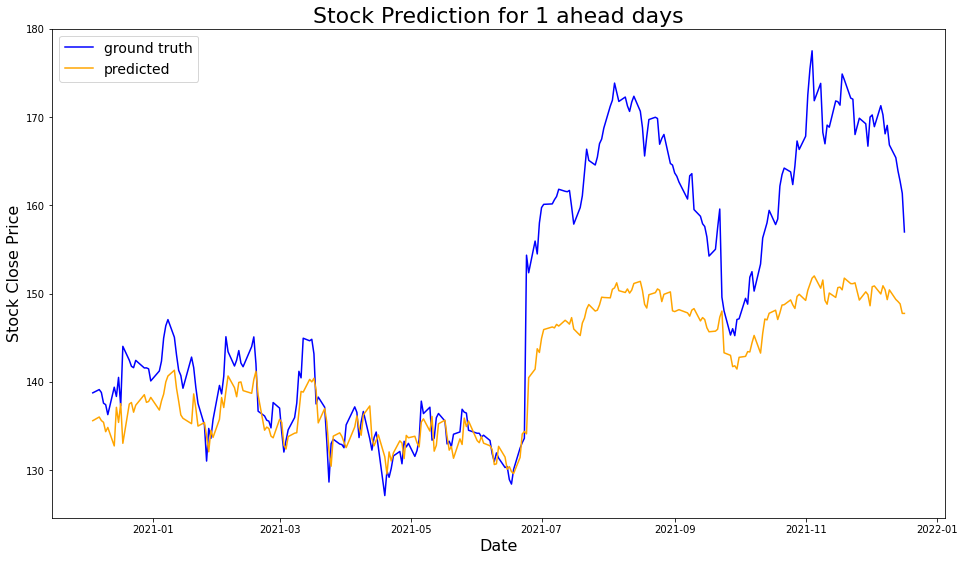

In [23]:
manager.visualize(n_ahead)

# Trading Strategy

In [24]:
from money_machine.trading.stock import Stock
from money_machine.trading.broker_account import BrokerAccount
from money_machine.trading.strategies import baseline_strategy, buy_on_min_roi
from money_machine.trading.simulation import simulate_trading
from money_machine.visualization.trading import plot_cumulative_value

In [25]:
stock = Stock(manager.y_test_pd)
stock_pred = Stock(pd.Series(manager.y_pred.flatten(), index=stock.dates.flatten()))

## Baseline

In [26]:
broker_account = BrokerAccount(stock, 10)
simulate_trading(baseline_strategy, broker_account, stock, stock_pred)
broker_account.print_results()

Account balance: 14.74 dollars
ROI: 47.41 %


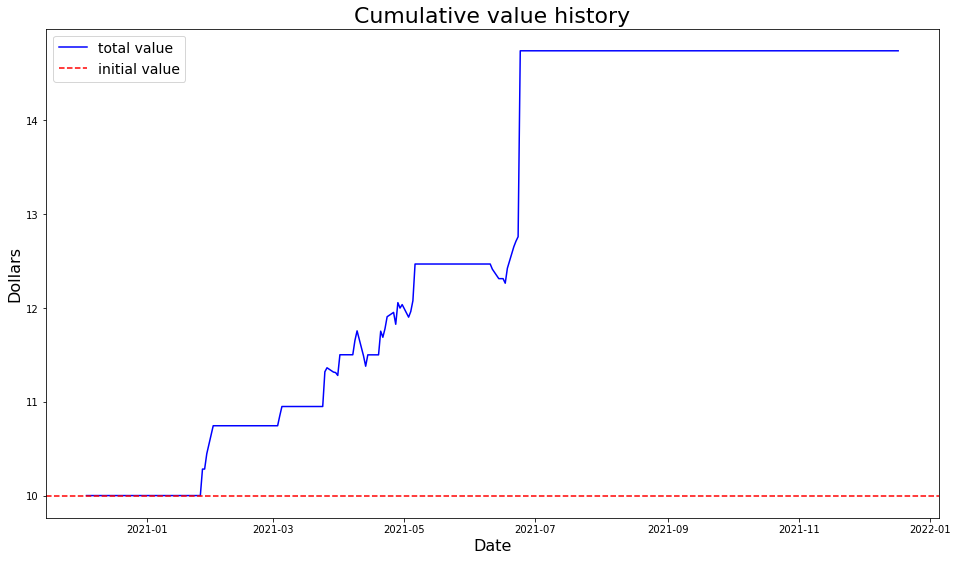

In [27]:
plot_cumulative_value(broker_account)

## Buy on ROI 5%

In [28]:
broker_account = BrokerAccount(stock, 10)
simulate_trading(buy_on_min_roi, broker_account, stock, stock_pred, 
                 roi = 0.05)
broker_account.print_results()

Account balance: 10.00 dollars
ROI: 0.00 %


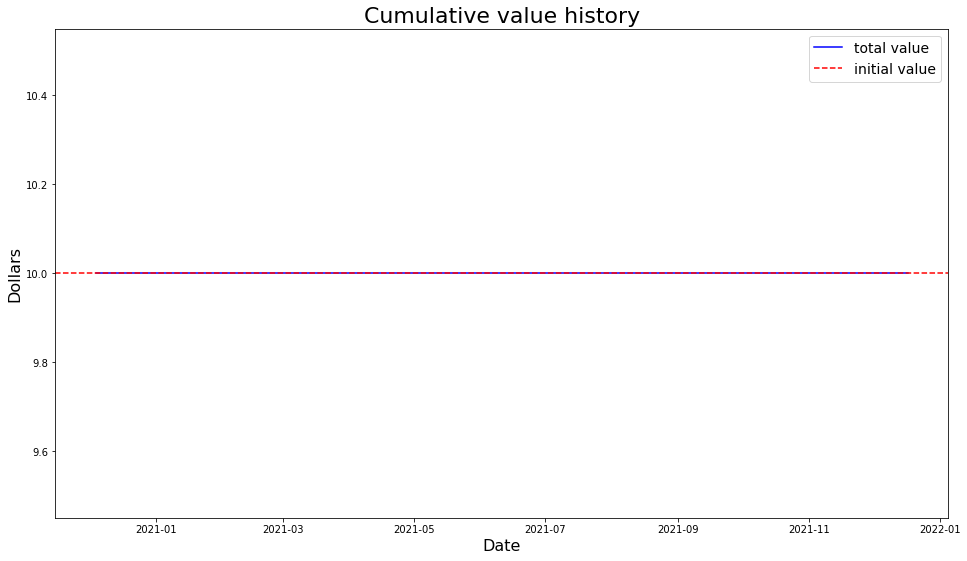

In [29]:
plot_cumulative_value(broker_account)